In [2]:
import glob
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.visualization import plot_fock_distribution, plot_wigner

import tqdm

import uuid
import json
import os

from thermophaseonium.utilities.make_gif import create_gif
from thermophaseonium.utilities.states import Cavity, Ancilla

In [3]:
SEED = 42
rng = np.random.default_rng(SEED)

OMEGA = 0.5  # Interaction strength
N = 100  # Maximum number of dimensions

INTERACTION_TIME = 0.005
T_MAX = 20
TIMESTEPS = np.linspace(0, T_MAX, int(T_MAX / INTERACTION_TIME))
print(f"Total of {len(TIMESTEPS)} timesteps from 0 to {T_MAX} with dt = {INTERACTION_TIME}")

FRAMES = TIMESTEPS[::int(len(TIMESTEPS) / 30)]
print(f"{len(FRAMES)} frames to be plotted")
FRAMES_PATH = "../visualization/dynamics/wigner"

Total of 4000 timesteps from 0 to 20 with dt = 0.005
31 frames to be plotted


## System

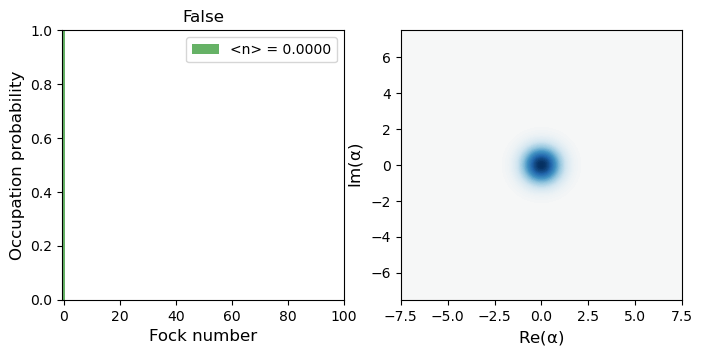

In [4]:
# Define the system
system_1 = Cavity(qt.thermal_dm(N, 0))
system_2 = qt.thermal_dm(N, 1)

# rho = qt.tensor(system_1, system_2)
rho = system_1
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))
rho.plot_fock_distribution(ax=axs[0])
rho.plot_wigner(ax=axs[1])
plt.show()

## Ancillas

In [5]:
def save_ancilla(ancilla):
    while True:
        save_id = str(uuid.uuid4())
        try:
            ancilla.save_parameters(save_id)
        except ValueError:
            print(f"ID {save_id} already exists, trying again")
        else:
            break
    return save_id


def create_ancilla(**entries):
    # This is a 3x3 system fully coherent
    alpha = entries.get('alpha', complex(rng.random(), 0))
    beta = entries.get('beta', complex(np.sqrt(1 - abs(alpha)**2), 0))
    
    chi01 = entries.get('chi01', complex(rng.random(), np.random.random()))
    chi02 = entries.get('chi02', complex(rng.random(), np.random.random()))
    # Ground-state coherence
    chi12 = entries.get('chi12', complex(rng.random(), np.random.random()))
    
    eta = np.array([
        [abs(alpha)**2, chi01, chi02], 
        [chi01.conjugate(), abs(beta)**2 / 2, chi12],
        [chi02.conjugate(), chi12.conjugate(), abs(beta)**2 / 2]
    ])
    ancilla = Ancilla(eta)
    save_id = save_ancilla(ancilla)

    return ancilla

alpha = np.sqrt(0.4)
chi01_phase = np.pi * 0
chi02_phase = np.pi * 0
chi12_phase = np.pi / 2

ancilla = create_ancilla(
    alpha=alpha, 
    chi01=np.cos(chi01_phase) + 1j * np.sin(chi01_phase),
    chi02=np.cos(chi02_phase) + 1j * np.sin(chi02_phase),
    chi12=np.cos(chi12_phase) + 1j * np.sin(chi12_phase))

ancilla

Ancilla with the same parameters already exists with ID dea8f47f-bdf1-4c3e-9bfc-dc3722dd3c3c


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[4.000000e-01+0.j 1.000000e+00+0.j 1.000000e+00+0.j]
 [1.000000e+00+0.j 3.000000e-01+0.j 6.123234e-17+1.j]
 [1.000000e+00+0.j 6.123234e-17-1.j 3.000000e-01+0.j]]

## Bosonic Operators

In [6]:
a = qt.destroy(N)
ad = a.dag()

ada = ad * a
aad = ada + 1

# Master Equation

In [7]:
def H_work(ancilla, omega=OMEGA):
    chi01 = ancilla.chi01
    chi02 = ancilla.chi02
    a = qt.destroy(N)
    upshift = (chi01 + chi02) * a.dag()
    return omega * (upshift + upshift.dag())

In [8]:
def D(op1, rho, op2=None):
    if op2 is None:
        op2 = op1
    return op1 * rho * op2.dag() - qt.commutator(op2.dag() * op1, rho, kind='anti') / 2

In [9]:
def onestep_evolution(rho, eta, dt=INTERACTION_TIME, o=OMEGA):
    work = 1j * o * dt * qt.commutator(H_work(eta), rho)
    heat1 = eta.ga * ( o * dt ) ** 2 * D(qt.create(N), rho)
    heat2 = eta.gb * ( o * dt ) ** 2 * D(qt.destroy(N), rho)
    rho_new = rho + work + heat1 + heat2
    return rho_new

In [18]:
def hilbert_is_good(rho, threshold=1e-6):
    """
    Check if the last element of the density matrix is almost null
    :param rho: 
    :return: 
    """
    return 0 <= abs(rho[-1, -1]) < threshold

In [19]:
def new_ancilla(ancilla, method='static', **kwargs):
    if method == 'static':
        return ancilla
    elif method == 'random':
        return create_ancilla()
    elif method == 'rotating':
        phis = np.linspace(0, 2 * np.pi, kwargs.get('timesteps', 10))
        ancilla.chi01 = phis[kwargs.get('step', -1)]
        ancilla.chi02 = phis[kwargs.get('step', -1)]
        return ancilla
    else:
        raise ValueError(f"Method {method} not recognized")


In [ ]:
rho = system_1
n_evolution = np.zeros(len(TIMESTEPS))
time_evolution = np.zeros(len(TIMESTEPS))
frames_name = f"wigner_{ancilla.json_id}"

for k, t in enumerate(tqdm.tqdm(TIMESTEPS)):
    eta_k = new_ancilla(ancilla, method='rotating', timesteps=len(TIMESTEPS), step=k)
    rho_new = onestep_evolution(rho, eta_k)
    rho = Cavity(rho_new)
    time_evolution[k] = t
    try:
        n_evolution[k] = rho.n
    except TypeError as e:
        print(f"Complex number of photons at step {k} with t = {t}")
        break
    if not hilbert_is_good(rho):
        print(f"Approximation no more valid at step {k} with t = {t}")
        break
    if t in FRAMES:
        rho.plot_wigner(
            title=f"Wigner function (t = {t:.2f})",
            show=False, 
            alpha_max=10,
            path=f"{FRAMES_PATH}/{k}_{frames_name}.png")

rho = Cavity(rho)

 45%|████▌     | 1810/4000 [00:41<00:32, 66.90it/s] 

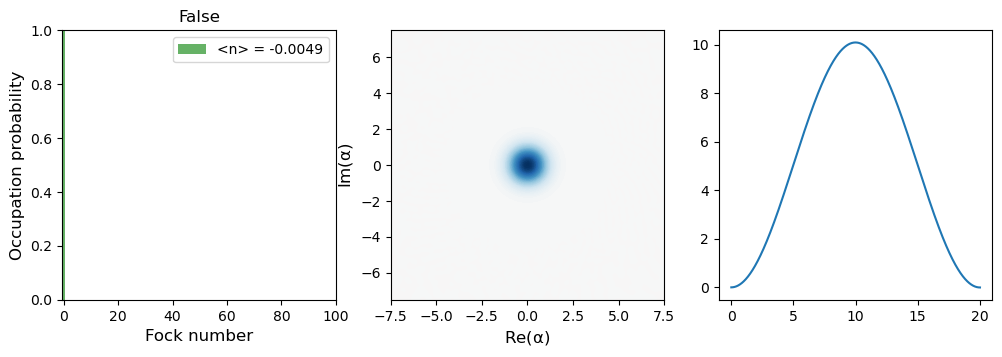

In [167]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
rho.plot_fock_distribution(ax=axs[0])
rho.plot_wigner(ax=axs[1])
axs[2].plot(time_evolution, n_evolution)

In [168]:
gif_name = create_gif(ancilla.json_id, FRAMES_PATH)

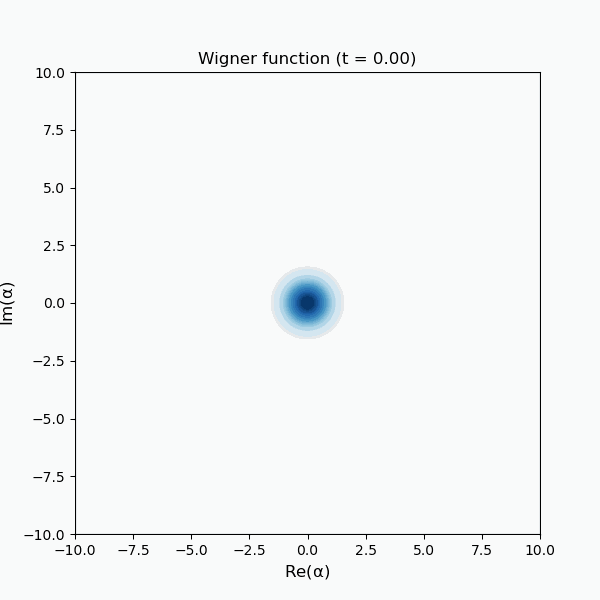

wigner_evolution_dea8f47f-bdf1-4c3e-9bfc-dc3722dd3c3c.gif


In [169]:
display(Image(filename=f"{FRAMES_PATH}/{gif_name}", width=10, height=10))
print(gif_name)